In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))
sys.path.append(str(Path("../..").resolve()))

from src.data_ingestion import *
from src.data_preprocessing import *


from pyspark.sql import DataFrame
from pyspark.sql.functions import col
from pyspark.sql.types import NumericType, StringType
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import seaborn as sns

import numpy as np

from itertools import combinations

from scipy import stats

import matplotlib.pyplot as plt

import pandas as pd



In [2]:
spark = init_spark()
df = load_data(spark, "../../data/US_Accidents_March23.csv")

In [15]:
# ── 1) Mining Frequent Itemsets & Rules with Spark FPGrowth ──────────────────────

from pyspark.ml.fpm import FPGrowth
import pyspark.sql.functions as F

# 1. Binarize Severity
df = df.withColumn(
    "SeverityBin",
    F.when(F.col("Severity") <= 2, "SeverityLow")
     .when(F.col("Severity") == 3, "SeverityMed")
     .otherwise("SeverityHigh")
)

# 2. Convert boolean columns to string
bool_cols = ["Amenity", "Traffic_Signal", "Roundabout"]
for c in bool_cols:
    df = df.withColumn(c, F.col(c).cast("string"))

# 2.5. Rename boolean values to meaningful names
for c in bool_cols:
    df = df.withColumn(
        c,
        F.when(F.col(c) == "true", f"{c}_True")
         .when(F.col(c) == "false", f"{c}_False")
         .otherwise(None)
    )

# 3. List of fields to collect
item_cols = ["SeverityBin", "Weather_Condition"] + bool_cols

# 4. Group by ID and collect sets
df_items = (
    df
    .select("ID", *item_cols)
    .na.drop(subset=item_cols)  # Drop rows where any item_col is null
    .groupBy("ID")
    .agg(
        F.collect_set("SeverityBin").alias("sev"),
        F.collect_set("Weather_Condition").alias("weather"),
        *[F.collect_set(c).alias(c) for c in bool_cols]
    )
    .withColumn("items_raw", F.flatten(F.array(*["sev", "weather", *bool_cols])))
)

# 5. Remove duplicates properly (Spark FPGrowth needs unique items)
df_items_clean = (
    df_items
    .withColumn("items", F.array_distinct(F.col("items_raw")))
    .select("ID", "items")
    .filter(
        (F.size("items") > 0) & (F.col("items").isNotNull())
    )
)

# 6. 📛 Filter out "boring" transactions that ONLY contain 'false'
df_items_filtered = df_items_clean.filter(
    ~(
        (F.size("items") == 1) &
        (F.array_contains(F.col("items"), "false"))
    )
)

# 7. Build FPGrowth model
fp = FPGrowth(itemsCol="items", minSupport=0.01, minConfidence=0.5)
model = fp.fit(df_items_filtered)

# 8. Extract results
freq_itemsets = model.freqItemsets
rules = model.associationRules

# 9. Convert to Pandas for later plotting
freq_pd = freq_itemsets.toPandas()
rules_pd = rules.toPandas()

# 10. Stringify lists for easier labels
freq_pd['itemset_str'] = freq_pd['items'].apply(lambda x: ', '.join(x))
rules_pd['antecedent_str'] = rules_pd['antecedent'].apply(lambda x: ', '.join(x))
rules_pd['consequent_str'] = rules_pd['consequent'].apply(lambda x: ', '.join(x))


C:\Users\Ahmed Osama\AppData\Local\Temp\ipykernel_24728\2906491418.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


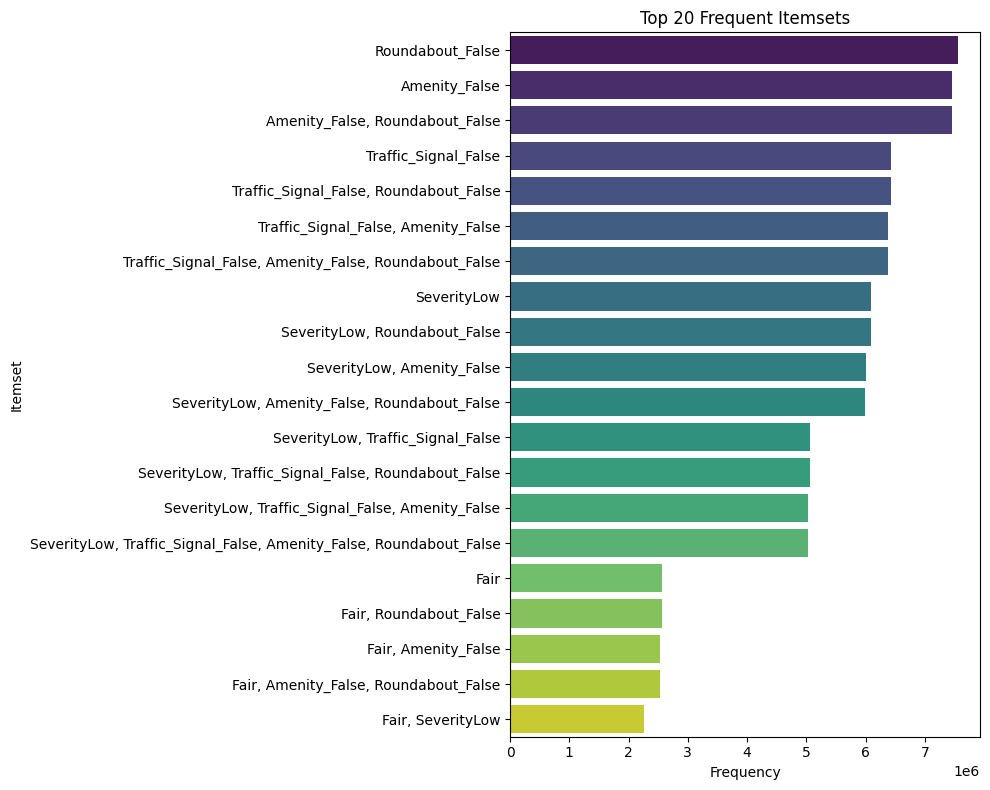

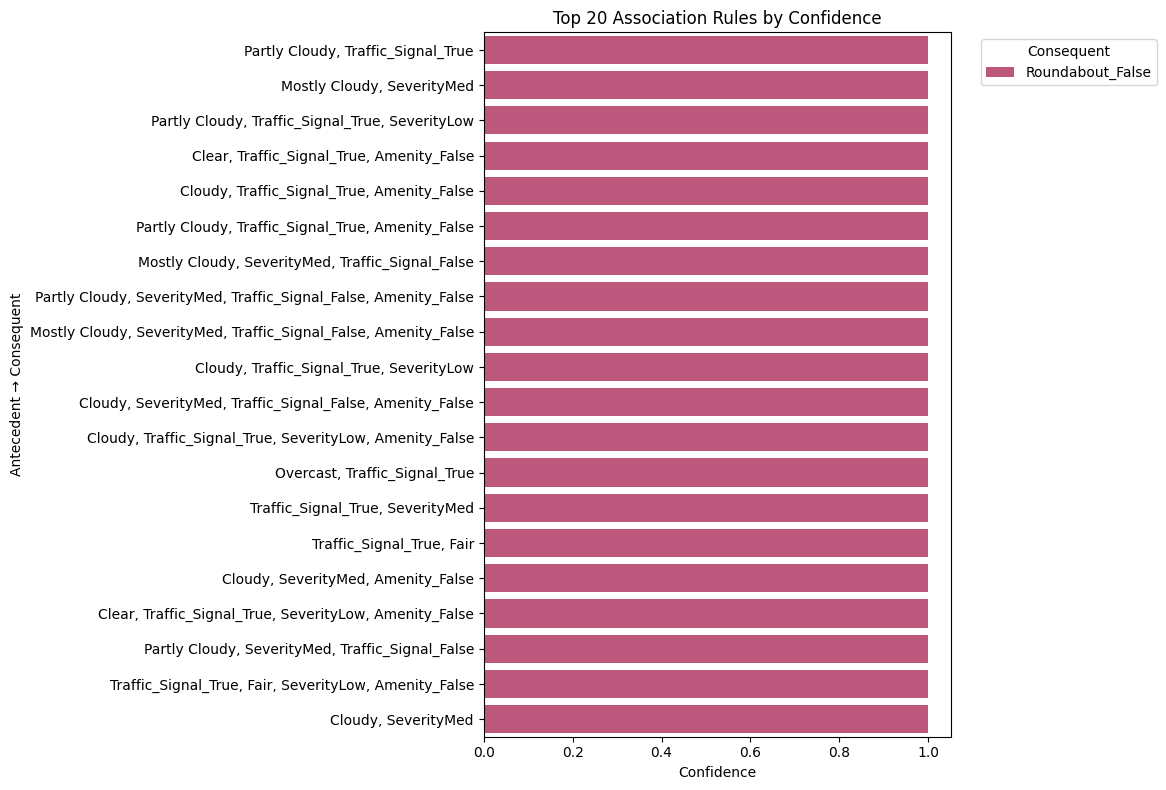


🔍 Top single frequent attributes:
                      items     freq           itemset_str
16       [Roundabout_False]  7554691      Roundabout_False
25          [Amenity_False]  7460419         Amenity_False
27   [Traffic_Signal_False]  6430577  Traffic_Signal_False
59            [SeverityLow]  6088612           SeverityLow
71                   [Fair]  2560802                  Fair
87            [SeverityMed]  1269042           SeverityMed
109   [Traffic_Signal_True]  1124358   Traffic_Signal_True
129         [Mostly Cloudy]  1016195         Mostly Cloudy
161                [Cloudy]   817082                Cloudy
193                 [Clear]   808743                 Clear

🔍 Top strongest association rules:
                                        antecedent_str    consequent_str  \
19                          Mostly Cloudy, SeverityMed  Roundabout_False   
27     Partly Cloudy, Traffic_Signal_True, SeverityLow  Roundabout_False   
28           Clear, Traffic_Signal_True, Amenity_Fal

In [16]:
# ── 2) Visualizing Frequent Itemsets ─────────────────────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Top 20 Frequent Itemsets
plt.figure(figsize=(10, 8))
top_freq = freq_pd.sort_values("freq", ascending=False).head(20)

sns.barplot(
    data=top_freq,
    y="itemset_str", x="freq",
    palette="viridis"
)
plt.title("Top 20 Frequent Itemsets")
plt.xlabel("Frequency")
plt.ylabel("Itemset")
plt.tight_layout()
plt.show()

# ── 3) Visualizing Association Rules ─────────────────────────────────────────────

# Plot Top 20 Association Rules by Confidence
plt.figure(figsize=(12, 8))
top_rules = rules_pd.sort_values("confidence", ascending=False).head(20)

sns.barplot(
    data=top_rules,
    x="confidence", y="antecedent_str",
    hue="consequent_str",
    dodge=False,
    palette="plasma"
)
plt.title("Top 20 Association Rules by Confidence")
plt.xlabel("Confidence")
plt.ylabel("Antecedent → Consequent")
plt.legend(title="Consequent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ── 4) Printing Quick Insights ───────────────────────────────────────────────────

# 1. Most common single attributes
print("\n🔍 Top single frequent attributes:")
single_items = freq_pd[freq_pd['items'].apply(lambda x: len(x) == 1)]
print(single_items.sort_values('freq', ascending=False).head(10))

# 2. Strongest rules
print("\n🔍 Top strongest association rules:")
print(
    rules_pd.sort_values(['confidence', 'lift'], ascending=False)[
        ["antecedent_str", "consequent_str", "confidence", "lift"]
    ].head(10)
)

# 3. Interesting example: rules leading to SeverityHigh
print("\n🔍 Rules leading to SeverityHigh accidents:")
severity_high_rules = rules_pd[
    rules_pd['consequent'].apply(lambda x: "SeverityHigh" in x)
]
print(
    severity_high_rules.sort_values(['confidence', 'lift'], ascending=False)[
        ["antecedent_str", "consequent_str", "confidence", "lift"]
    ].head(10)
)


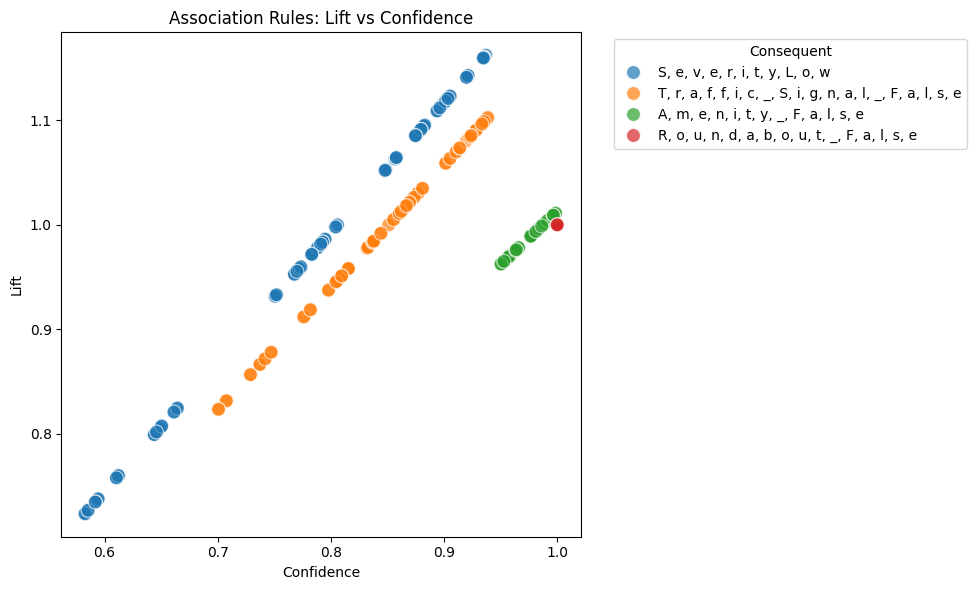

In [17]:
# ── 5) Scatter Plot: Lift vs Confidence ──────────────────────────────────────────

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=rules_pd,
    x="confidence", y="lift",
    hue=rules_pd['consequent_str'].apply(lambda x: ', '.join(x)),
    palette="tab10",
    s=100, alpha=0.7
)
plt.title("Association Rules: Lift vs Confidence")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.legend(title="Consequent", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


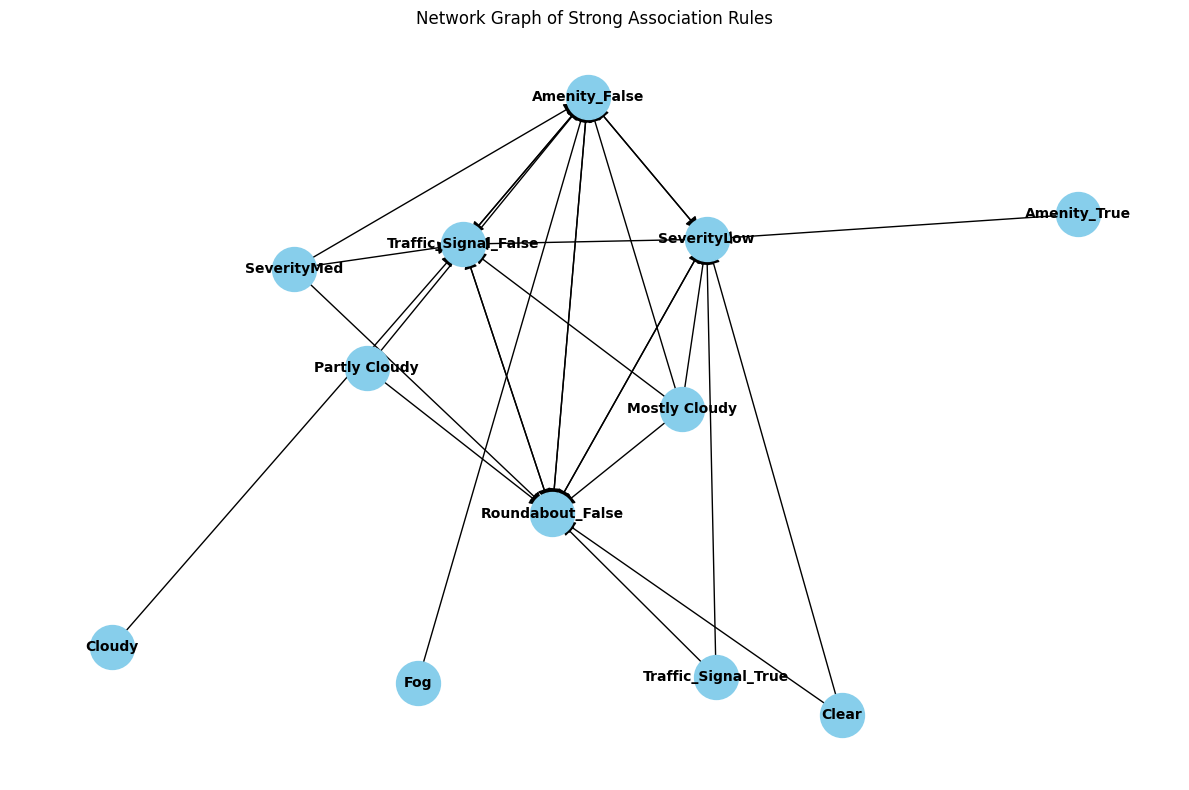

In [18]:
# ── 6) Network Graph of Strong Rules ─────────────────────────────────────────────

import networkx as nx

# Filter top rules with high confidence & lift
top_n_rules = rules_pd[
    (rules_pd['confidence'] >= 0.8) & (rules_pd['lift'] > 1.0)
].head(20)

# Build graph
G = nx.DiGraph()

for _, row in top_n_rules.iterrows():
    for ant in row['antecedent']:
        for cons in row['consequent']:
            G.add_edge(ant, cons, weight=row['confidence'])

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)
# Draw edges
edges = G.edges(data=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='-|>', arrowsize=20)

# Labels
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("Network Graph of Strong Association Rules")
plt.axis('off')
plt.tight_layout()
plt.show()


In [9]:
# Filter: Only keep rows where the label is not 'false'
filtered_transactions = transactions[transactions.apply(lambda x: "false" not in x)]

# Then rerun Apriori and FPGrowth
itemsets_apriori_filtered = apriori(filtered_transactions, min_support=0.001, use_colnames=True)
itemsets_fpgrowth_filtered = fpgrowth(filtered_transactions, min_support=0.001, use_colnames=True)

# And re-extract rules
rules_apriori_filtered = association_rules(itemsets_apriori_filtered, metric="confidence", min_threshold=0.7)
rules_fpgrowth_filtered = association_rules(itemsets_fpgrowth_filtered, metric="confidence", min_threshold=0.7)


NameError: name 'transactions' is not defined